# Write a function ```get_normalize``` that takes a tensor with object features from some image dataset and returns the channel-wise mean and channel-wise standard deviation.
The matrix is guaranteed to have dimensions [N, C, H, W], where N is the number of objects, C is the number of channels, and H and W are the image dimensions. You need to return a tuple of two tensors of length C.

Your function should have the following signature:
```def get_normalize(features: torch.Tensor):```



In [1]:
import torch
import torchvision.transforms as T

def get_normalize(features: torch.Tensor):

    mean = torch.mean(features, dim=(0, 2, 3))
    std_dev = torch.std(features, dim=(0, 2, 3))
    

    return (mean, std_dev)

In [2]:
tensor = torch.FloatTensor(5, 3, 2, 2) 
tensor


tensor([[[[-9.0458e-26,  4.4973e-41],
          [-1.1192e+19,  3.1472e-41]],

         [[-9.0458e-26,  4.4973e-41],
          [-9.0458e-26,  4.4973e-41]],

         [[ 0.0000e+00,  0.0000e+00],
          [ 4.2039e-45,  0.0000e+00]]],


        [[[-9.0457e-26,  1.4013e-45],
          [ 1.5414e-44,  4.4973e-41]],

         [[ 0.0000e+00,  0.0000e+00],
          [ 3.6013e-43,  0.0000e+00]],

         [[-1.1224e+19,  3.1472e-41],
          [ 2.1853e+25,  4.4975e-41]]],


        [[[ 1.8888e+31,  1.1330e+33],
          [ 7.2436e+22,  0.0000e+00]],

         [[-1.1198e+19,  3.1472e-41],
          [ 1.3593e-43,  0.0000e+00]],

         [[-1.1227e+19,  3.1472e-41],
          [ 2.1853e+25,  4.4975e-41]]],


        [[[ 4.2039e-44,  0.0000e+00],
          [ 1.5695e-43,  0.0000e+00]],

         [[ 6.7262e-44,  0.0000e+00],
          [ 6.7262e-44,  0.0000e+00]],

         [[-7.2263e-17,  3.1476e-41],
          [ 4.7428e+30,  7.5884e+31]]],


        [[[-9.0070e-26,  4.4973e-41],
          [-9.0458

In [3]:
mean, std = get_normalize(tensor)

mean

tensor([ 5.7595e+31, -5.5990e+17,  4.0313e+30])

In [4]:
from torchvision.datasets import CIFAR10 
dataset_train = CIFAR10('/kaggle/input/cifar10', train=True, transform=T.ToTensor())

In [5]:
means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

In [6]:
stds

array([0.24703223, 0.24348513, 0.26158784])

# Write a function get_augmentations that will return ready-made augmentations for the training sample and for the test sample. 

It should have the following signature: ```def get_augmentations(train: bool = True) -> T.Compose:```.

Apply the following augmentations:

 - Resize the image to 224 by 224 pixels (for both the training and test samples).
 
 - Apply some of the augmentations we learned in class (for the training sample only).
 
 - Convert the image to a tensor.
 
 - Apply normalization for the CIFAR10 dataset.
 
It is clear that resizing to 224 by 224 and normalization for CIFAR10 do not work well together. Therefore, in the future, when you use this function to obtain augmentations for your new dataset, do not forget to change them to those specific to it.

In [7]:
def get_augmentations(train: bool = True) -> T.Compose:
    
    means = (0.49139968, 0.48215841, 0.44653091)
    stds = (0.24703223, 0.24348513, 0.26158784)
    
    if train:
        train_transforms = T.Compose(
        [
            #T.Resize(size=(224, 224)),
            T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
            T.RandomHorizontalFlip(p=0.5),
            #T.RandomRotation(degrees = 20),
            T.RandomResizedCrop(size=32, scale=(0.7, 1.1)),
            T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
            T.RandomAdjustSharpness(sharpness_factor=2),
            #T.GaussianBlur(kernel_size=(3, 7), sigma=(0.2, 3)),
            #T.RandomAdjustSharpness(sharpness_factor=4),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )
        
    else:
        
        train_transforms = T.Compose(
        [
            #T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=means, std=stds)
        ]
        )
        
    return train_transforms


# Write a ```predict``` function.
It should take a neural network, data loader, and torch.device as input. It should have the following signature: 
```def predict(model: nn.Module, loader: DataLoader, device: torch.device):```

Inside the function, do the following steps:

- Create an empty list to store predictions.

- Iterate over the data loader.

- On each iteration, do a forward pass for the batch, calculate the classes as argmax on the neural network output, on the logs, add the tensor with predictions to the list.
- Concatenate all predictions and return this tensor of length N, according to the number of objects in the dataset.

Your function should return a tensor with classes.

In [8]:
import torch.nn as nn
from torch.utils.data import DataLoader

@torch.inference_mode()
def predict(model: nn.Module, loader: DataLoader, device: torch.device):
    
    model.eval()
    
    predicts =[]
    
    for x, y in loader:
        
        x, y = x.to(device), y.to(device)

        output = model(x)
        
        y_pred = torch.argmax(output, 1)
        
        predicts.append(y_pred)

    return  torch.cat(predicts)

# Train a model with two convolutional layers on the CIFAR10 dataset and achieve an Accuracy metric of 70% on the test sample.

The only restrictions are on the number of convolutional layers in the model architecture; you can use any cool tricks we covered in class. You need to submit code with a function that returns the model. Name this function ```create_simple_conv_cifar```. It does not accept any arguments and returns the model. Also submit a prediction for the CIFAR10 dataset test sample using the predict function from the previous assignment. Use torch.save to write the tensor with the prediction result to disk.

In [9]:
dataset_train = CIFAR10('/kaggle/input/cifar10', train=True, transform=get_augmentations(1))
dataset_valid = CIFAR10('/kaggle/input/cifar10', train=False, transform=get_augmentations(0))
dataset_valid_extra = CIFAR10('/kaggle/input/cifar10', train=False, transform=get_augmentations(1))

train_loader = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)
valid_loader_extra = DataLoader(dataset_valid_extra, batch_size=128, shuffle=False, num_workers=4, pin_memory=True)

In [10]:
from IPython.display import clear_output
from time import perf_counter
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

#!g1.1
from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        #scheduler.step()
        
        if valid_accuracy >= 0.885:
            
            break


In [11]:
#!g1.1

def create_simple_conv_cifar():
    class FirstModel(nn.Module):
        def __init__(self):
            super().__init__()

            self.net = nn.Sequential(
                nn.Conv2d(in_channels=3, 
                          out_channels=32, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 16
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 16 x 16 x 16
                nn.Dropout2d(p=0.2),

                nn.Conv2d(in_channels=32, 
                          out_channels=64, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 16 x 16 x 64
                nn.BatchNorm2d(64),
                nn.ReLU(),

                nn.MaxPool2d(2),  # 8 x 8 x 64
                nn.Dropout2d(p=0.2),

                nn.Flatten(),

                nn.Linear(8 * 8 * 64, 1024),
                nn.BatchNorm1d(1024),
                nn.Dropout(p=0.1),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(p=0.1),
                nn.ReLU(),
                nn.Linear(256, 10)
            )

        def forward(self, x):
            return self.net(x)
    return FirstModel()

# Write the ```predict_tta``` function. 

It should accept a neural network, a data loader, torch.device, and the number of iterations per data loader as input. It should have the following signature: 
```def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):```.

In this function, we will apply the technique we briefly discussed in class — **Test Time Augmentation**. The main idea is to make several augmented versions of each image from the test sample and make predictions for them. Then, these predictions are averaged and used as usual. In PyTorch syntax, this degenerates into creating a test dataset with random augmentations (either as in the training sample or slightly weaker). After that, you need to iterate over the created dataset several times and average the model's responses.

Inside the function, do the following steps:

- Start a loop for the number of iterations.
- Inside the loop, iterate over the data loader.
- Write the model's responses (not classes, but raw neural network outputs) to one large tensor of size [N, C], where C is the number of classes and N is the number of objects in the dataset (i.e., we must have a vector of neural network outputs, logits, for each object).
- Make one huge tensor of size [N, C, iterations] from these tensors, average it over iterations so that its size becomes [N, C].
- Next, predict the classes for objects based on this tensor as argmax, return them from the function.

Your function should return a tensor with classes. Don't forget to switch the model to application mode and attach a detector to disable gradient calculation.

In [12]:
@torch.inference_mode()
def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    
    model.eval()
    
    predicts_list = []
    
    for i in range(iterations):
        
        predicts = []
        
        for x, y in loader:
                x, y = x.to(device), y.to(device)
                
                out = torch.unbind((torch.Tensor(model(x))))
                
                for i in out:
                    predicts.append(i)
                       
        predicts_tensor = torch.stack(predicts)
        predicts_list.append(predicts_tensor)
    
    predict_list_tensor = torch.stack(predicts_list)

    predict_list_tensor = torch.mean(predict_list_tensor, 0)
    
    classes_tensor = torch.argmax(predict_list_tensor, 1)

    return classes_tensor, accuracy

In [13]:
a = []
for i in range(10):
    
    a.append(torch.rand(10))

    
torch.stack(a)

tensor([[0.5437, 0.4794, 0.8418, 0.8433, 0.0153, 0.0783, 0.1624, 0.2022, 0.4088,
         0.6281],
        [0.5536, 0.5233, 0.4266, 0.4754, 0.2650, 0.2185, 0.1302, 0.7100, 0.4976,
         0.0338],
        [0.3865, 0.1627, 0.6160, 0.0492, 0.3354, 0.4512, 0.9809, 0.4049, 0.3383,
         0.0348],
        [0.8193, 0.9734, 0.1698, 0.6245, 0.3721, 0.8403, 0.5395, 0.2688, 0.9943,
         0.6134],
        [0.2294, 0.7491, 0.8892, 0.2105, 0.6536, 0.4281, 0.6777, 0.0066, 0.7652,
         0.2092],
        [0.9903, 0.2655, 0.1191, 0.0225, 0.9834, 0.7483, 0.3965, 0.5173, 0.4562,
         0.1496],
        [0.8962, 0.7613, 0.2666, 0.5776, 0.3281, 0.1311, 0.4196, 0.3085, 0.7651,
         0.4628],
        [0.6046, 0.8205, 0.9665, 0.1768, 0.0546, 0.9068, 0.4539, 0.0120, 0.0074,
         0.0428],
        [0.8511, 0.3364, 0.0727, 0.6965, 0.9166, 0.6971, 0.3092, 0.3502, 0.8019,
         0.6175],
        [0.3900, 0.5127, 0.3852, 0.6912, 0.1328, 0.0111, 0.0794, 0.7049, 0.3018,
         0.9823]])

# Train any model on the CIFAR10 dataset and achieve an Accuracy metric of 88% on the test sample. 

You need to submit code with a function that returns the model. Name this function ```create_advanced_conv_cifar```. It does not accept any arguments and returns the model. 

Also submit a prediction for the CIFAR10 dataset test sample, use the ```predict_tta``` function from the previous task (compare the results using regular predict and predict_tta, evaluate the quality gain provided by the latter). To use ```predict_tta```, you need to create a separate test data loader with augmentations. Use ```torch.save``` to write the tensor with the prediction result to disk.

In [14]:
def create_advanced_conv_cifar():
    
    model = nn.Sequential(
                nn.Conv2d(in_channels=3, 
                          out_channels=32, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 32
                nn.BatchNorm2d(32),
                nn.ReLU(),

                nn.Conv2d(in_channels=32, 
                          out_channels=64, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 32
                nn.BatchNorm2d(64),
                nn.ReLU(),
                
                nn.Conv2d(in_channels=64, 
                          out_channels=64, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 32 x 32 x 64
                nn.BatchNorm2d(64),
                nn.ReLU(),
             
                nn.MaxPool2d(2),  # 16 x 16 x 64
                nn.Dropout2d(p=0.2),

        
                nn.Conv2d(in_channels=64, 
                          out_channels=128, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 16 x 16 x 64
                nn.BatchNorm2d(128),
                nn.ReLU(),
        
                nn.Conv2d(in_channels=128, 
                          out_channels=256, 
                          kernel_size=3, 
                          padding=1, 
                          padding_mode='reflect'),  # 16 x 16 x 256
                nn.BatchNorm2d(256),
                nn.ReLU(),
        
                nn.MaxPool2d(2),  # 8 x 8 x 256
                nn.Dropout2d(p=0.1),
        
                nn.Conv2d(in_channels=256, 
                  out_channels=512, 
                  kernel_size=3, 
                  padding=0),  # 6 x 6 x 512
                nn.BatchNorm2d(512),
                nn.ReLU(),

                nn.Conv2d(in_channels=512, 
                  out_channels=1024, 
                  kernel_size=3, 
                  padding=0),  # 4 x 4 x 1024
                nn.BatchNorm2d(1024),
                nn.ReLU(),
        
                nn.MaxPool2d(2), # 2 x 2 x 1024
                nn.Dropout2d(p=0.1),

                nn.Flatten(),

                nn.Linear(2 * 2 * 1024, 1024),
                nn.BatchNorm1d(1024),
                nn.Dropout(p=0.2),
                nn.ReLU(),
                nn.Linear(1024, 256),
                nn.BatchNorm1d(256),
                nn.Dropout(p=0.1),
                nn.ReLU(),
                nn.Linear(256, 10)
            )

    return model

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

model = create_advanced_conv_cifar().to(device)

cuda:0


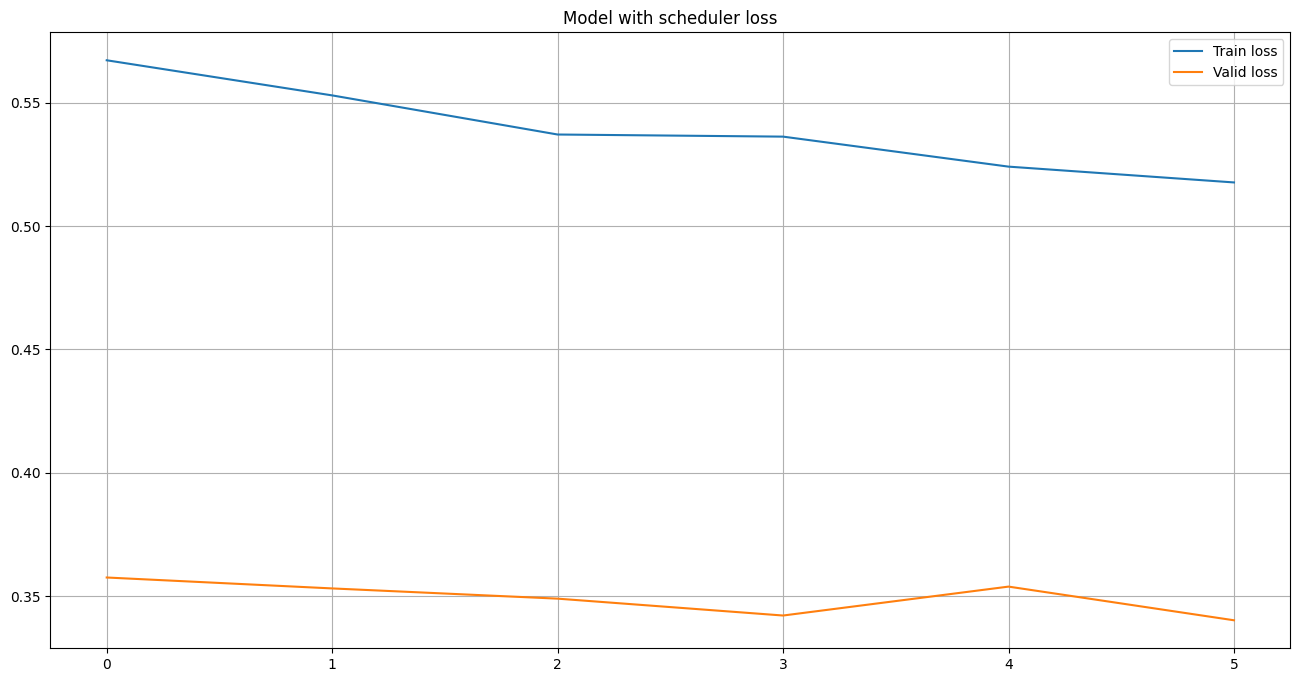

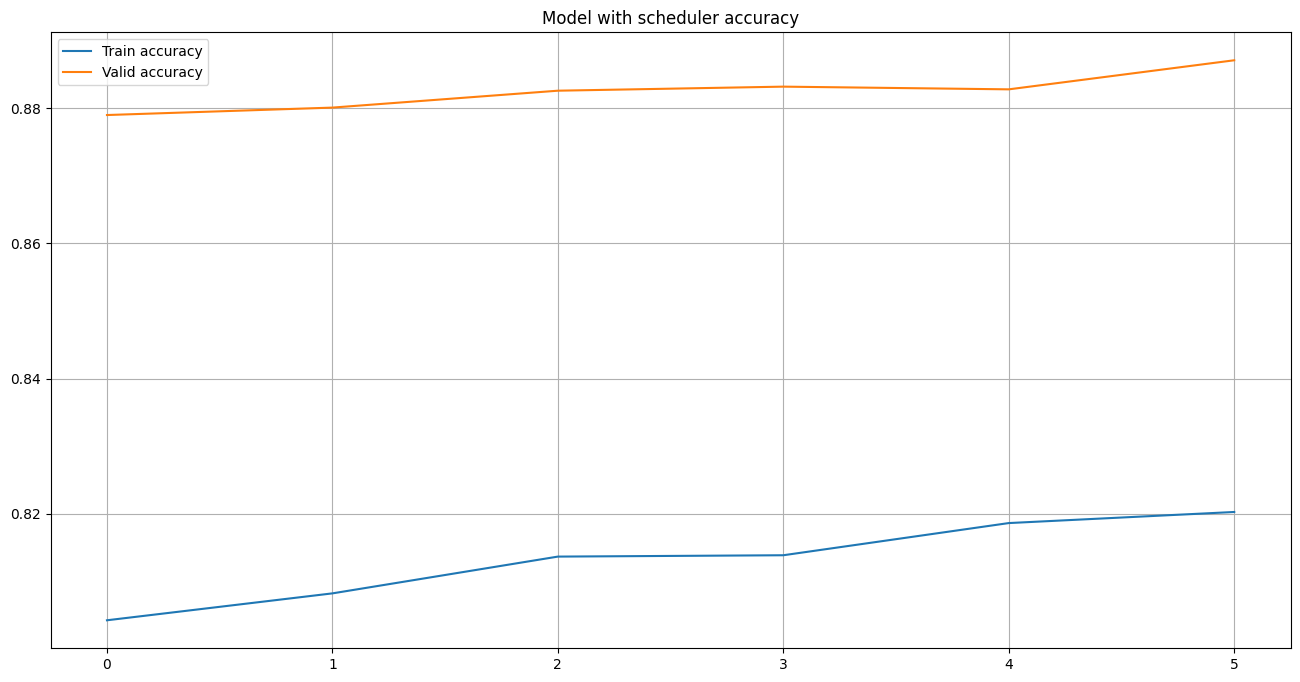

In [21]:
from torch.optim import Adam

optimizer = torch.optim.Adam(model.parameters(), lr=25e-5)

loss_fn = nn.CrossEntropyLoss()

scheduler = StepLR(optimizer, step_size=10)

whole_train_valid_cycle(model, 10, 'Model with scheduler')

In [ ]:
predicts = predict(model, valid_loader, device)


In [ ]:
valid_loss, valid_accuracy = evaluate(model, valid_loader)
valid_accuracy

In [ ]:
predict_tta(model, valid_loader_extra, device, 4)

In [ ]:
torch.save(predicts, 'predicts.pt')

In [ ]:
torch.save(model.state_dict(), '0.885_CIFAR10_model.pt')